In [1]:
import copy
import numpy as np
#import aplpy
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
from astropy.cosmology import FlatLambdaCDM

[{'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0, 'theta_E': 5.8285487062874966}]


/home/jimenagonzalez/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in log10


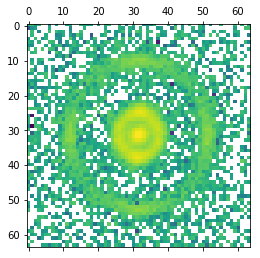

In [2]:
LSST_camera = {'read_noise': 10,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.263,  # scale (in arcseonds) of pixels
               'ccd_gain': 4.5  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }
LSST_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 21.7,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 10,  # number of exposures that are combined
                   'seeing': 0.6,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'psf_model': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

numpix = 64
kwargs_g_band = util.merge_dicts(LSST_camera, LSST_g_band_obs)
kwargs_numerics = {'point_source_supersampling_factor': 1}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [0.8],  # list of redshift of the deflections
                          'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  # list of extended source models to be used
                          'source_redshift_list': [1., 2.5],  # list of redshfits of the sources in same order as source_light_model_list
                          'cosmo': cosmo,  # astropy.cosmology instance
                          'z_source_convention': 3,  # source redshfit to which the reduced deflections are computed, is the maximal redshift of the ray-tracing
                          'z_source': 3,  # redshift of the default source (if not further specified by 'source_redshift_list') and also serves as the redshift of lensed point sources
    }

sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical, kwargs_numerics=kwargs_numerics)

kwargs_mass = [{'sigma_v': 600, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0}]

sim = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical, kwargs_numerics=kwargs_numerics)

imSim = sim.image_model_class

kwargs_lens = sim.physical2lensing_conversion(kwargs_mass=kwargs_mass)
print(kwargs_lens)

#point source light
kwargs_ps_mag_g = [{'magnitude': 21, 'ra_source': 0.03, 'dec_source': 0}]
#lens light
kwargs_lens_light_mag_g = [{'magnitude': 20, 'R_sersic': .6, 'n_sersic': 4, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0}]
# source light
kwargs_source_mag_g = [{'magnitude': 22, 'R_sersic': 0.4, 'n_sersic': 2, 'e1': -0.3, 'e2': -0.2, 'center_x': 0, 'center_y': 0},
                      {'magnitude': 23, 'R_sersic': 0.8, 'n_sersic': 3, 'center_x': 0., 'center_y': 0}]
kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)


image_g = imSim.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
image_g += sim.noise_for_model(model=image_g)

plt.matshow(np.log10(image_g))
plt.show()